# Testing FFTW for fully periodic fluid flows

Here we test the methods, in FFTW, to be used in the pseudo-spectral code described previously.

We start by loading the packages we need:

In [1]:
using FFTW
using CairoMakie
using Test

## The spatial domain and its spatial discretization

We consider a square domain of sides $L = 2\pi$, for which the smallest wavenumber is $\kappa_0 = 2\pi/L$.

In [2]:
L = 2π
κ₀ = 2π/L

1.0

We set the number $N$ of points for the mesh in each direction, yielding a mesh $(x_i, y_j)_{i, j = 1,\ldots ,N}$, with $x_N = y_N = L$, and steps $x_{i+1} - x_i = L/N$, and $y_{j+1} - y_j = L/N$. Due to the periodicity, we don't need to store the values corresponding to $i = j = 0$.

In [3]:
N = 128
x = y = (L/N):(L/N):L
nothing

We may visualize the grid with a scatter plot, although if the mesh is too thin, we won't quite see the details. But if using GLMakie or WGLMakie, one can zoom in for a detailed view.

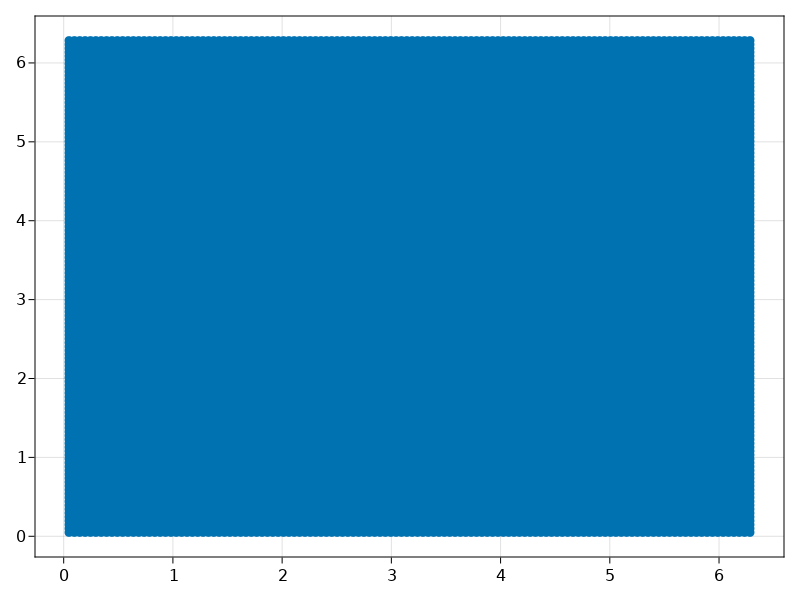

In [4]:
fig, ax, plt = scatter(vec(x .* one.(y)'), vec(one.(x) .* y'))

fig

## A vorticity function for testing

In order to test the methods from [FFTW.jl](http://www.fftw.org), we define a certain vorticity function and its derivatives

In [5]:
vort = sin.(one.(y) * x') .* cos.(3y * one.(x)')
dx_vort = cos.(one.(y) * x') .* cos.(3y * one.(x)')
dy_vort = - 3 * sin.(one.(y) * x') .* sin.(3y * one.(x)')
dd_vort = - sin.(one.(y) * x') .* cos.(3y * one.(x)') - 9 * sin.(one.(y) * x') .* cos.(3y * one.(x)')

nothing

We may visualize the vorticity as a surface:

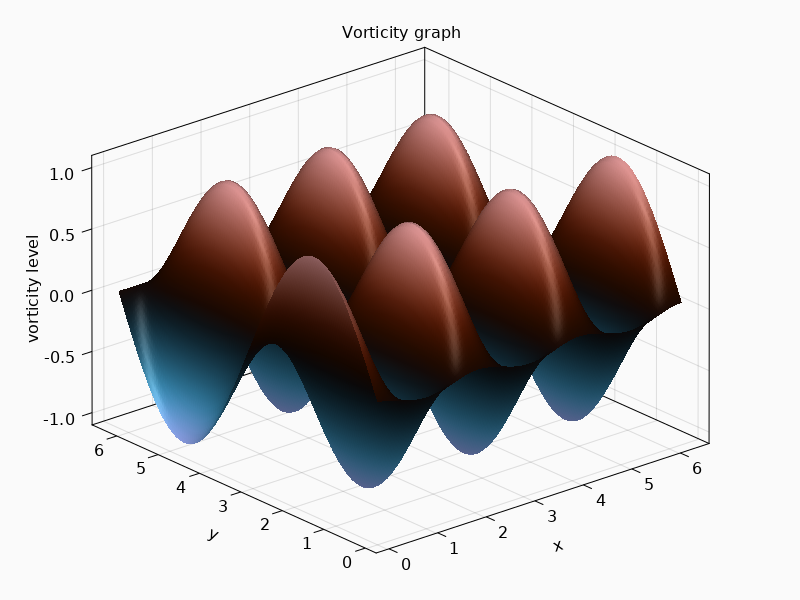

In [6]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98))

ax = Axis3(fig[1, 1], xlabel = "x", ylabel = "y", zlabel = "vorticity level", title = "Vorticity graph")

surface!(ax, x, y, vort, colormap = :berlin)

fig

Or, better yet, as a heatmap:

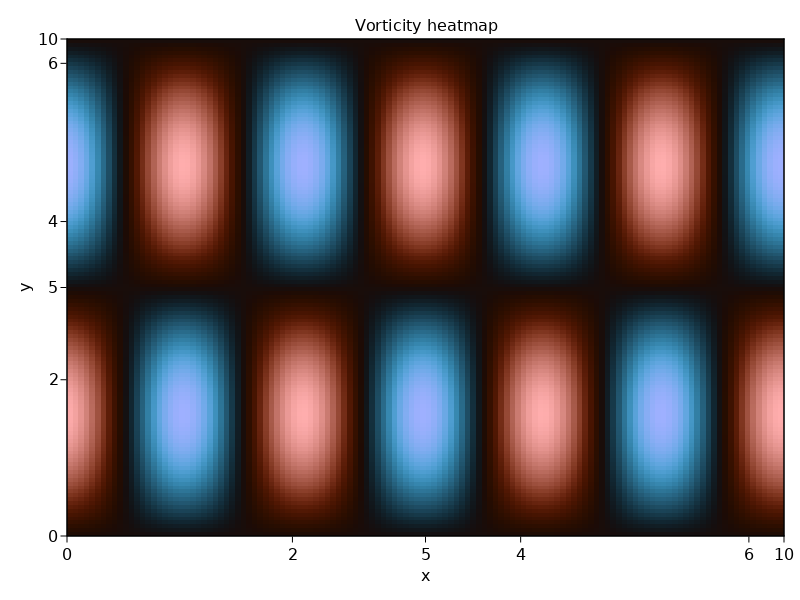

In [7]:
fig, ax, plt = heatmap(x, y, vort, colormap = :berlin)

ax = Axis(fig[1, 1], xlabel = "x", ylabel = "y", title = "Vorticity heatmap")

fig

## Testing the direct and inverse discrete Fourier transform

We check going back and forth with the real fft and inverse real fft:

In [8]:
@testset "check composition `irfft ∘ rfft`" begin
    vort_hat = rfft(vort)
    vortback = irfft(vort_hat, N)
    @test vort ≈ vortback
end
nothing

Test Summary:                    | Pass  Total
check composition `irfft ∘ rfft` |    1      1


## Differential operators

In order to check the derivatives in spectral space, we define the following operators. Actually, they are just vectors, since derivatives in spectral space act as diagonal operators.

In [9]:
Dx_hat = im * κ₀ * [ifelse(k1 ≤ N/2 + 1, k1 - 1, k1 - 1 - N) for k2 in 1:N/2+1, k1 in 1:N]
Dy_hat = im * κ₀ * [k2 - 1 for k2 in 1:N/2+1, k1 in 1:N]

Delta_hat = - κ₀^2 * [
    ifelse(k1 ≤ N/2 + 1, (k1 - 1)^2 + (k2 - 1)^2, (k1 - 1 - N)^2 + (k2 - 1)^2)
    for k2 in 1:N/2+1, k1 in 1:N
]

Hu_hat = - Dy_hat ./ Delta_hat
Hu_hat[1, 1] = 0.0
Hv_hat = Dx_hat ./ Delta_hat
Hv_hat[1, 1] = 0.0

nothing

## Testing the spectral operators

Now we are ready to test the differentiation in spectral space, with the operators just defined.

In [10]:
@testset "Check operators" begin
    vort_hat = rfft(vort)
    u_hat = Hu_hat .* vort_hat
    v_hat = Hv_hat .* vort_hat
    # check derivative dx in spectral space:
    @test irfft(Dx_hat .* vort_hat, N) ≈ dx_vort
    # check derivative dy in spectral space:
    @test irfft(Dy_hat .* vort_hat, N) ≈ dy_vort
    # check Laplacian in spectral space:
    @test Delta_hat ≈ Dx_hat.^2 .+ Dy_hat.^2
    @test irfft(Delta_hat .* vort_hat, N) ≈ dd_vort
    # check recovering velocity field from vorticity
    @test Dx_hat .* v_hat - Dy_hat .* u_hat ≈ vort_hat
end
nothing

Test Summary:   | Pass  Total
Check operators |    5      5


## One-mode steady state

For forced-periodic flows, when the forcing function contains a single Fourier mode, there is a corresponding steady state vorticity function corresponding also to a single-mode in Fourier space, which is the same as that for the forcing. Only the energy is different.

In order to construct such pairs of forcing mode / steady state, we set define the viscosity of the flow, choose the mode to be forced and define the strength of that force:

In [11]:
ν = 1.0e-0 # viscosity
κ = (x = 1, y = 2) # forced mode
α = (re = 0.1, im = 0.05) # strength

nothing

With these parameters, we find the curl `g_steady` of the forcing term and the vorticity `vort_steady` of the corresponding steady-state:

In [12]:
g_steady = ν * (
    2α.re * κ₀^4 * sum(abs2, κ)^2 * cos.(κ₀ * (κ.x * one.(y) * x' + κ.y * y * one.(x)'))
    - 2α.im * κ₀^4 * sum(abs2, κ)^2 * sin.(κ₀ * (κ.x * one.(y) * x' + κ.y * y * one.(x)'))
)

vort_steady = 2κ₀^2 * sum(abs2, κ) * (
    α.re * cos.(κ₀ * (κ.x * one.(y) * x' + κ.y * y * one.(x)'))
    - α.im * sin.(κ₀ * (κ.x * one.(y) * x' + κ.y * y * one.(x)'))
)
nothing

Here are some visualizations of the curl of the forcing term and of the vorticity

In [13]:
heatmap(x, y, g_steady, xlabel="x", ylabel="y", title="Curl of the forcing term", titlefont=12)

heatmap(x, y, vort_steady, xlabel="x", ylabel="y", title="Steady state vorticity", titlefont=12)

nothing

The discrete Fourier transform of this vector fields are given as

In [14]:
g_steady_hat = rfft(g_steady)

vort_steady_hat = rfft(vort_steady)

nothing

## Testing the steady state

We are now ready to test the steadyness of this vorticity field:

In [15]:
@testset "Check single-mode stable steady state" begin
    u_steady_hat = Hu_hat .* vort_steady_hat
    v_steady_hat = Hv_hat .* vort_steady_hat

    u_steady = irfft(u_steady_hat, N)
    v_steady = irfft(v_steady_hat, N)

    vort_steady_back = irfft(vort_steady_hat, N)

    wu_steady_hat = rfft(vort_steady_back .* u_steady)
    wv_steady_hat = rfft(vort_steady_back .* v_steady)

    rhs_steady = g_steady_hat .+ Delta_hat .* vort_steady_hat .- Dx_hat .* wu_steady_hat .- Dy_hat .* wv_steady_hat

    vort_steady_sol_hat = - g_steady_hat ./ Delta_hat
    vort_steady_sol_hat[1, 1] = 0.0im
    # Vanishing bilinear term on one-mode steady state
    @test maximum(abs.(Dx_hat .* wu_steady_hat .+ Dy_hat .* wv_steady_hat)) ≤ √eps()
    # Vanishing RHS on steady state
    @test maximum(abs.(rhs_steady)) ≤ √eps()
    # Vanishing linear Stokes on steady state
    @test maximum(abs.(g_steady_hat .+ Delta_hat .* vort_steady_hat)) ≤ √eps()

    # Steady state equation
    @test g_steady_hat ≈ - Delta_hat .* vort_steady_hat ≈ - Delta_hat .* vort_steady_hat .- Dx_hat .* wu_steady_hat .- Dy_hat .* wv_steady_hat

    # Steady state solution
    @test vort_steady_sol_hat ≈ vort_steady_hat
end
nothing

Test Summary:                         | Pass  Total
Check single-mode stable steady state |    5      5
